In [67]:
from google.colab import drive
drive.mount('/content/drive')

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer
from sklearn.impute import SimpleImputer


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 전처리

In [86]:
data_folder = '/content/drive/MyDrive/2months_data/2months_data'
all_files = os.listdir(data_folder)
csv_files = [os.path.join(data_folder, f) for f in all_files if f.endswith('.csv')]

def read_csv_file(file_path):
    encodings = ['utf-8', 'cp949', 'euc-kr']  # List of possible encodings
    for encoding in encodings:
        try:
            return pd.read_csv(file_path, encoding=encoding)
        except (UnicodeDecodeError, pd.errors.EmptyDataError, pd.errors.ParserError):
            continue
    raise ValueError(f"Could not read file {file_path} with any encoding.")

valid_dataframes = []
for file in csv_files:
    try:
        df = read_csv_file(file)
        if not df.empty:
          valid_dataframes.append(df)
    except ValueError as e:
        print(e)

if valid_dataframes:
    combined_data = pd.concat(valid_dataframes, ignore_index=True)
else:
    combined_data = pd.DataFrame()
combined_data.columns=["Creation date", "load factor", "Set Pressure", "Boiler Pressure",
                      "Blower Inverter Output", "Blower Input", "Water Supply Pump",
                      "Water Supply Pump Input", "Gas Damper", "Gas Damper Input",
                      "Air Damper", "Air Damper Input", "Recirculation Damper",
                      "Recirculation External Damper", "Recirculation Damper Input",
                      "Recirculation External Damper Input", "Water Supply Level",
                      "Boiler Temperature", "Exhaust Gas Temperature 1",
                      "Exhaust Gas Temperature 2", "Exhaust Gas Temperature 3",
                      "Exhaust Recirculation Temperature", "Economizer Temperature 1",
                      "Economizer Temperature 2", "Burner Temperature", "Exhaust Gas NOx",
                      "Exhaust Gas O2", "Recirculation O2", "Recirculation NOx",
                      "Water Supply Amount (Cumulative Flow)",
                      "Water Supply Amount (Instantaneous Flow)",
                      "Fuel Amount (Cumulative Flow)", "Fuel Amount (Instantaneous Flow)",
                      "Efficiency (Instantaneous)", "Power Consumption", "Vibration Sensor 1",
                      "Vibration Sensor 2", "Operating Time", "Normal Operation Probability",
                      "Blower Failure Probability", "Air Damper Failure Probability",
                      "Gas Damper Failure Probability", "Probability Update Time",
                      "Instantaneous Steam Amount", "Input-Output Efficiency",
                      "Heat Loss Efficiency", "Efficiency (input/output method-steam)"]

combined_data = combined_data.reset_index()
combined_data = combined_data.shift(periods=1, axis=1)
combined_data = combined_data.drop(columns=['index'])

combined_data = combined_data.drop(columns=[
    "Creation date","Power Consumption","Vibration Sensor 1","Vibration Sensor 2","Operating Time",
    "Normal Operation Probability","Blower Failure Probability","Air Damper Failure Probability",
    "Gas Damper Failure Probability","Probability Update Time","Instantaneous Steam Amount",
    "Input-Output Efficiency","Heat Loss Efficiency","Efficiency (Instantaneous)",
    "Exhaust Recirculation Temperature","Burner Temperature"
])

numeric_columns = combined_data.select_dtypes(include=['float64', 'int64']).columns
combined_data[numeric_columns] = combined_data[numeric_columns].apply(lambda col: col.fillna(col.mean()))

# scaler = StandardScaler()
# combined_data[numeric_columns] = scaler.fit_transform(combined_data[numeric_columns])

# # Encode categorical variables (if any)
# label_encoder = LabelEncoder()
# for column in combined_data.select_dtypes(include=['object']).columns:
#     combined_data[column] = label_encoder.fit_transform(combined_data[column])

# combined_data.to_csv('/content/drive/MyDrive/preprocessed_boiler_data.csv', index=False, encoding='utf-8')

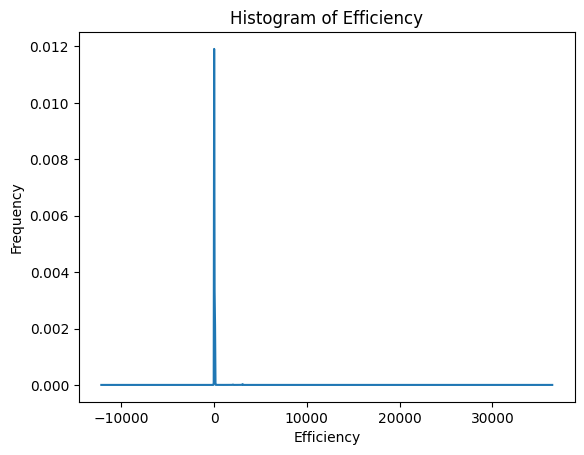

In [55]:
import matplotlib.pyplot as plt

# 히스토그램
combined_data['Efficiency (input/output method-steam)'].plot(kind='density')
plt.xlabel('Efficiency')
plt.ylabel('Frequency')
plt.title('Histogram of Efficiency')
plt.show()

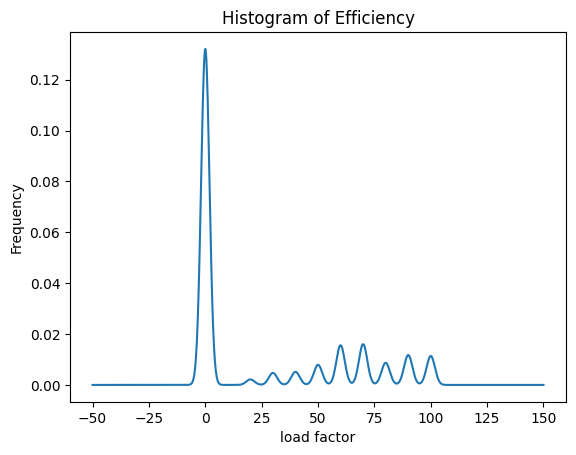

In [56]:
combined_data['load factor'].plot(kind='density')
plt.xlabel('load factor')
plt.ylabel('Frequency')
plt.title('Histogram of Efficiency')
plt.show()

In [87]:
combined_data = combined_data[combined_data['load factor'] != 0]

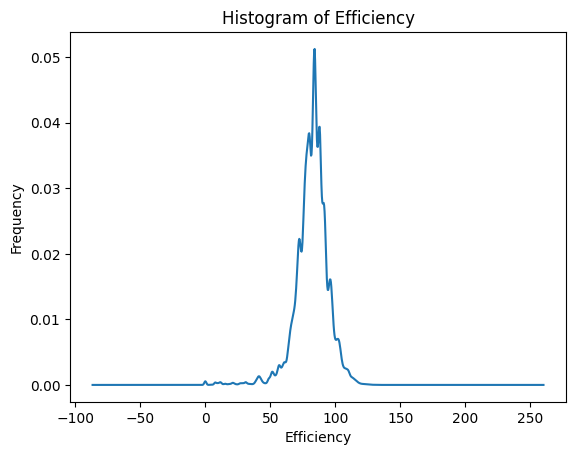

In [60]:
combined_data['Efficiency (input/output method-steam)'].plot(kind='density')
plt.xlabel('Efficiency')
plt.ylabel('Frequency')
plt.title('Histogram of Efficiency')
plt.show()

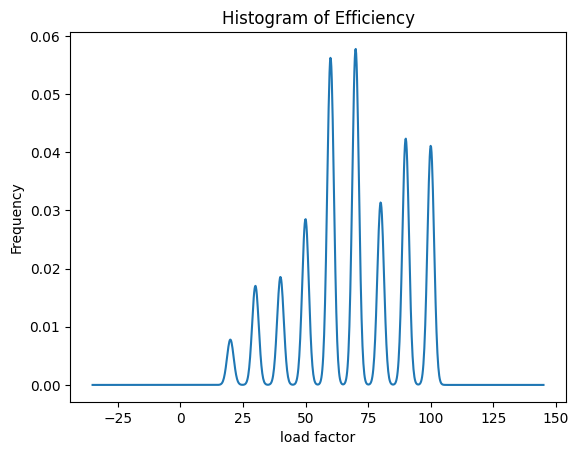

In [59]:
combined_data['load factor'].plot(kind='density')
plt.xlabel('load factor')
plt.ylabel('Frequency')
plt.title('Histogram of Efficiency')
plt.show()

In [88]:
scaler = RobustScaler()
combined_data[numeric_columns] = scaler.fit_transform(combined_data[numeric_columns])

combined_data.to_csv('/content/drive/MyDrive/preprocessed_boiler_data.csv', index=False, encoding='utf-8')

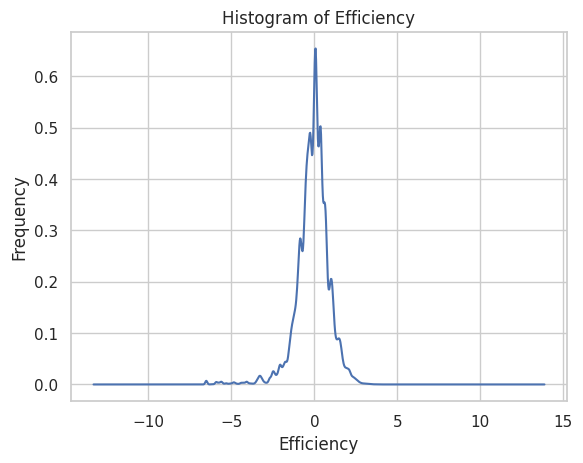

In [89]:
combined_data['Efficiency (input/output method-steam)'].plot(kind='density')
plt.xlabel('Efficiency')
plt.ylabel('Frequency')
plt.title('Histogram of Efficiency')
plt.show()

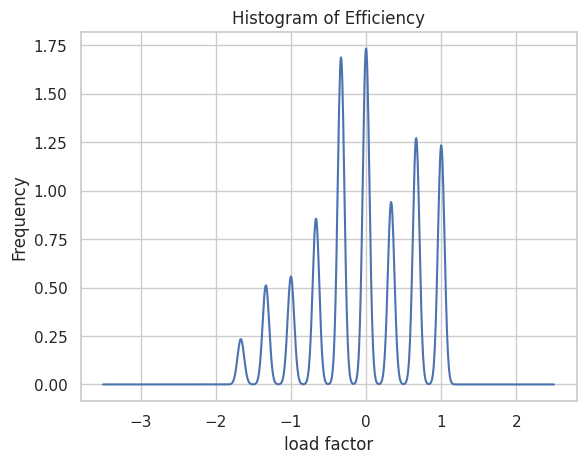

In [90]:
combined_data['load factor'].plot(kind='density')
plt.xlabel('load factor')
plt.ylabel('Frequency')
plt.title('Histogram of Efficiency')
plt.show()

## 중요도 추출 모델 (RF 모델)

In [91]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from scipy.stats import randint

# combined_data = 전처리된 데이터프레임 (전처리 코드는 이미 실행된 상태라고 가정)
combined_data = read_csv_file('/content/drive/MyDrive/preprocessed_boiler_data.csv')

# 독립 변수(X)와 종속 변수(y) 설정
X = combined_data.drop(columns=['Efficiency (input/output method-steam)'])  # 종속 변수 제외
y = combined_data['Efficiency (input/output method-steam)']

# 데이터 분할: 훈련 데이터와 테스트 데이터로 분할
# 여기에서 train_test_split을 사용하여 X_train, X_test, y_train, y_test를 생성
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest Model with RandomizedSearchCV for hyperparameter tuning
rf = RandomForestRegressor(random_state=42,
                           n_estimators=50,
                           min_weight_fraction_leaf=0.0,
                           min_samples_leaf=1,
                           min_samples_split=5,
                           max_features='sqrt',
                           max_depth=25)

rf.fit(X_train, y_train)

# Define the hyperparameter grid
# param_distributions = {
#     'n_estimators': [50, 100, 200],      # Number of trees
#     'max_depth': [None, 10, 15, 20, 25],           # Maximum depth of the tree
#     'min_samples_split': [2,5,10],   # Minimum number of samples required to split an internal node
#     'min_samples_leaf': [1,2,4],    # Minimum number of samples required to be at a leaf node
#     'max_features':['sqrt', 'log2'],  # Number of features to consider at each split
#     'min_weight_fraction_leaf': [0.0, 0.1, 0.2]  # 리프 노드의 가중치 샘플 최소값
# }

# Randomized Search CV with 5-fold cross-validation
# random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_distributions,
#                                    n_iter=50, cv=5, verbose=2, n_jobs=-1, random_state=42)
# random_search.fit(X_train, y_train)

# Best parameters
# print("Best hyperparameters found by RandomizedSearchCV:")
# print(random_search.best_params_)

# Model evaluation using test data
# y_pred = random_search.predict(X_test)
y_pred = rf.predict(X_test)

# Calculate performance metrics
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
mae = np.mean(np.abs(y_test - y_pred))
rmse = np.sqrt(np.mean((y_test - y_pred) ** 2))
mse = np.mean((y_test - y_pred) ** 2)

print(f"MAPE: {mape:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MSE: {mse:.4f}")

MAPE: inf
MAE: 0.3240
RMSE: 0.4398
MSE: 0.1934


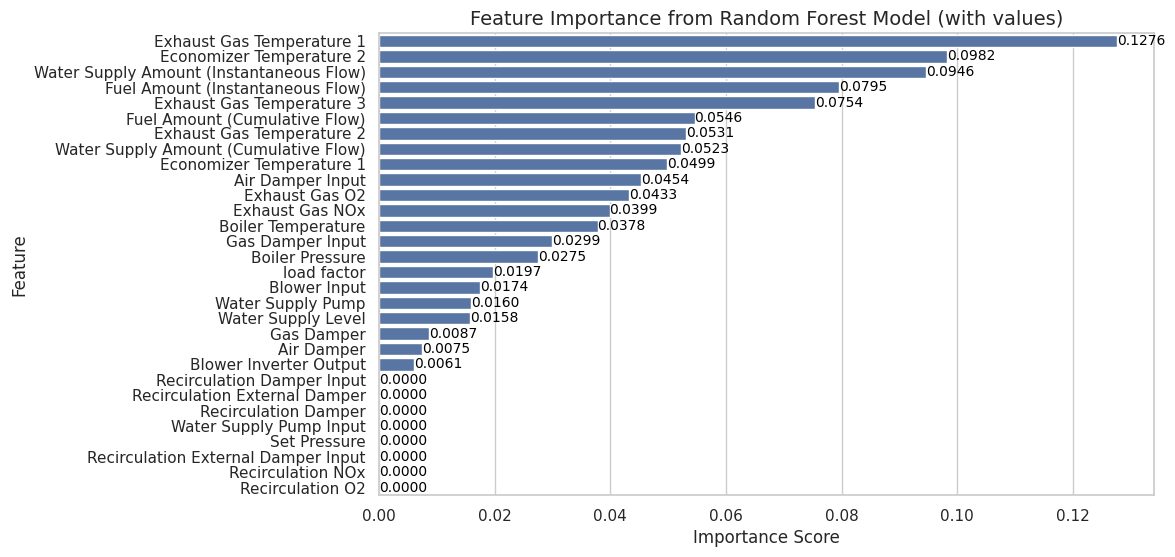

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.font_manager as fm
import shutil

# Seaborn 스타일 적용
sns.set(style="whitegrid")

# 예시 데이터 (random_search.best_estimator_는 미리 학습된 상태여야 함)
feature_importances = rf.feature_importances_
features = X.columns  # 각 피처의 이름

# 피처 중요도를 시리즈로 변환하고, 중요도 순서대로 정렬
feature_importance_series = pd.Series(feature_importances, index=features).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=feature_importance_series, y=feature_importance_series.index)

# 각 바에 중요도 값을 텍스트로 표시
for i, (value, name) in enumerate(zip(feature_importance_series, feature_importance_series.index)):
    ax.text(value, i, f'{value:.4f}', va='center', ha='left', fontsize=10, color='black')

plt.title('Feature Importance from Random Forest Model (with values)', fontsize=14)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.show()

In [99]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from scipy.stats import randint

# combined_data = 전처리된 데이터프레임 (전처리 코드는 이미 실행된 상태라고 가정)

# 독립 변수(X)와 종속 변수(y) 설정
reduced_X = combined_data.loc[:, features[:16]]  # 종속 변수 제외
y = combined_data['Efficiency (input/output method-steam)']

# 데이터 분할: 훈련 데이터와 테스트 데이터로 분할
# 여기에서 train_test_split을 사용하여 X_train, X_test, y_train, y_test를 생성
X_train, X_test, y_train, y_test = train_test_split(reduced_X, y, test_size=0.2, random_state=42) # 예시: 80% 훈련, 20% 테스트

# Random Forest Model with RandomizedSearchCV for hyperparameter tuning
# reduced_rf = RandomForestRegressor(random_state=42,
#                                    n_estimators=200,
#                                    min_weight_fraction_leaf=0.0,
#                                    min_samples_split=2,
#                                    min_samples_leaf=4,
#                                    max_features='sqrt',
#                                    max_depth=20)

reduced_rf = RandomForestRegressor(random_state=42)

# Define the hyperparameter grid
param_distributions = {
    'n_estimators': [50, 100, 150, 200],      # Number of trees
    'max_depth': [None, 10, 15, 20, 25],           # Maximum depth of the tree
    'min_samples_split': [2,5,10,12.5,15],   # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1,2,4],    # Minimum number of samples required to be at a leaf node
    'max_features':['sqrt', 'log2'],  # Number of features to consider at each split
    'min_weight_fraction_leaf': [0.0, 0.1, 0.2]  # 리프 노드의 가중치 샘플 최소값
}

# # Randomized Search CV with 5-fold cross-validation
reduced_random_search = RandomizedSearchCV(estimator=reduced_rf, param_distributions=param_distributions,
                                   n_iter=50, cv=5, verbose=2, n_jobs=-1, random_state=42)
reduced_random_search.fit(X_train, y_train)

# # Best parameters
print("Best hyperparameters found by RandomizedSearchCV:")
print(reduced_random_search.best_params_)

# Model evaluation using test data
y_pred = reduced_random_search.predict(X_test)
# y_pred = reduced_rf.fit(X_train, y_train).predict(X_test)


# Calculate performance metrics
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
mae = np.mean(np.abs(y_test - y_pred))
rmse = np.sqrt(np.mean((y_test - y_pred) ** 2))
mse = np.mean((y_test - y_pred) ** 2)

print(f"MAPE: {mape:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MSE: {mse:.4f}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best hyperparameters found by RandomizedSearchCV:
{'n_estimators': 50, 'min_weight_fraction_leaf': 0.0, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 20}
MAPE: inf
MAE: 0.6122
RMSE: 0.8553
MSE: 0.7316


## 최적화 모델

In [69]:
from scipy.optimize import minimize

def predict_efficiency(params):
    params = np.array(params).reshape(1, -1)
    params = pd.DataFrame(params, columns=reduced_X.columns.tolist())
    efficiency = reduced_rf.predict(params)
    return efficiency[0]

def loss_function(params):
    return -predict_efficiency(params)

initial_params = X_train.iloc[0].values

result = minimize(loss_function, initial_params, method='BFGS')

optimized_params = result.x
optimized_efficiency = -result.fun

print("최적화된 인자:", optimized_params)
print("최적화된 보일러 효율:", optimized_efficiency)

최적화된 인자: [ 3.37507799e-14 -3.33453071e-01 -7.90717047e-01 -7.90194764e-01
 -5.82834214e-01  0.00000000e+00 -6.85908206e-01 -6.80123935e-01
 -7.22602968e-01 -7.43064626e-01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.81769390e-01 -3.76144104e-01]
최적화된 보일러 효율: -0.7439719756147308


In [75]:
import torch

# PyTorch로 최적화할 변수 초기값 정의
x_init = torch.tensor(X_train.iloc[0].values, requires_grad=True)  # 초기값

# 최적화 설정
learning_rate = 0.01
iterations = 1000
optimizer = torch.optim.SGD([x_init], lr=learning_rate)

# 경사하강법을 통한 최적화
loss_history = []

for i in range(iterations):
    optimizer.zero_grad()  # 이전 기울기 초기화

    # PyTorch 텐서를 NumPy 배열로 변환하여 예측값 계산
    x_np = x_init.detach().numpy().reshape(1, -1)
    pred = reduced_rf.predict(pd.DataFrame(x_np, columns=X_train.columns))

    # 손실 함수: 예측 값의 음수 (최소화 대상)
    loss = -pred
    loss = torch.tensor(loss, requires_grad=True)

    # 역전파를 통한 기울기 계산
    loss.backward()
    optimizer.step()  # 경사하강법으로 x_init 업데이트

    # 손실 값 저장 및 중간 진행 상황 출력
    loss_history.append(loss.item())
    if i % 100 == 0:
        print(f"Iteration {i}: Loss = {-loss.item()}")

# 최적의 x 조합과 손실 값 출력
print("Optimal x:", x_init.detach().numpy())
print("Optimal loss:", -reduced_rf.predict(pd.DataFrame((x_init.detach().numpy().reshape(1, -1)), columns=reduced_X.columns.tolist())))

Iteration 0: Loss = -0.7439719756147308
Iteration 100: Loss = -0.7439719756147308
Iteration 200: Loss = -0.7439719756147308
Iteration 300: Loss = -0.7439719756147308
Iteration 400: Loss = -0.7439719756147308
Iteration 500: Loss = -0.7439719756147308
Iteration 600: Loss = -0.7439719756147308
Iteration 700: Loss = -0.7439719756147308
Iteration 800: Loss = -0.7439719756147308
Iteration 900: Loss = -0.7439719756147308
Optimal x: [ 3.37507799e-14 -3.33453071e-01 -7.90717047e-01 -7.90194764e-01
 -5.82834214e-01  0.00000000e+00 -6.85908206e-01 -6.80123935e-01
 -7.22602968e-01 -7.43064626e-01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.81769390e-01 -3.76144104e-01]
Optimal loss: [0.74397198]


In [78]:
!pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 2.8 MB/s eta 0:00:00


In [79]:
from skopt import gp_minimize
from skopt.space import Real

# 목적 함수 정의
def objective_function(x):
    # x를 2D로 변환하여 예측 수행
    pred = reduced_rf.predict(pd.DataFrame([x], columns=X_train.columns))
    return -pred[0]  # minimize the negative efficiency

# 변수 범위 정의 (예: 각 변수 범위)
space = [Real(0, 10) for i in range(X_train.shape[1])]  # 조정 필요

# 베이지안 최적화 실행
result = gp_minimize(objective_function, space, n_calls=50, random_state=42)
print("Optimal x:", result.x)
print("Optimal efficiency:", -result.fun)

Optimal x: [0.0, 4.0785944233991565, 4.962771450005517, 8.66119749094129, 10.0, 9.79253729756657, 0.0, 0.0, 10.0, 4.741614730350927, 0.38648368811366623, 0.0, 9.388398275504928, 10.0, 10.0, 10.0]
Optimal efficiency: 2.5394922885416453


In [ ]:
from scipy.optimize import differential_evolution

# 목적 함수 정의
def objective_function(x):
    pred = reduced_rf.predict(pd.DataFrame(x.reshape(1, -1), columns=X_train.columns))
    return -pred[0]  # maximize efficiency by minimizing the negative

# 파라미터 범위 정의 (예: 각 파라미터 값의 범위)
bounds = [(combined_data[col].min(), combined_data[col].max()) for i, col in X_train.columns]  # 각 변수의 최소/최대값에 따라 조정

# Differential Evolution 최적화 실행
result = differential_evolution(objective_function, bounds)
print("Optimal x:", result.x)
print("Optimal efficiency:", -result.fun)

## 전처리 원상복구

In [70]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

# 최적화된 상태의 데이터
optimized_data = pd.DataFrame(columns=combined_data.columns)
optimized_data.loc[0] = [0 for _ in range(len(combined_data.columns))]

for i, col in enumerate(features[:16]):
  if optimized_data.dtypes[i] == 'int64':
    optimized_data.loc[0, col] = int(optimized_params[i])
  else:
     optimized_data.loc[0, col] = optimized_params[i]
optimized_data['Efficiency (Instantaneous)'] = optimized_efficiency


# 데이터 스케일링 및 레이블 인코딩

# 1. 역 스케일링 (StandardScaler를 사용한 스케일링 복구)
# 숫자형 열에 대해 StandardScaler로 스케일링된 값을 원래 값으로 복구
optimized_data[numeric_columns] = scaler.inverse_transform(optimized_data[numeric_columns][numeric_columns].values)

#2. 역 레이블 인코딩 (LabelEncoder를 사용한 범주형 데이터 복구)
# 범주형 열들을 레이블 인코딩 이전의 원래 값으로 복구
for column in combined_data.select_dtypes(include=['object']).columns:
    optimized_data[column] = label_encoder.inverse_transform(optimized_data[column])

#복구된 데이터 확인

print(optimized_data.head())

   load factor  Set Pressure  Boiler Pressure  Blower Inverter Output  \
0          5.6      5.291384        29.901738               29.479031   

   Blower Input  Water Supply Pump  Water Supply Pump Input  Gas Damper  \
0     19.081713                0.0                16.510196     17.0819   

   Gas Damper Input  Air Damper  ...  Economizer Temperature 2  \
0          18.56013   18.708367  ...                         0   

   Exhaust Gas NOx  Exhaust Gas O2  Recirculation O2  Recirculation NOx  \
0        13.373154             0.0               0.0        9741.931241   

   Water Supply Amount (Cumulative Flow)  \
0                               0.686158   

   Water Supply Amount (Instantaneous Flow)  Fuel Amount (Cumulative Flow)  \
0                              652133.82487                      44.555996   

   Fuel Amount (Instantaneous Flow)  Efficiency (Instantaneous)  
0                        413.410982                    0.984625  

[1 rows x 31 columns]


<ipython-input-70-10788bb266b6>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if optimized_data.dtypes[i] == 'int64':
<ipython-input-70-10788bb266b6>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if optimized_data.dtypes[i] == 'int64':
<ipython-input-70-10788bb266b6>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if optimized_data.dtypes[i] == 'int64':
<ipython-input-70-10788bb266b6>:11: FutureWarning: Series.__getitem__ 

In [72]:
optimized_data.to_csv('/content/drive/MyDrive/optimized_boiler_data.csv', index=False, encoding='utf-8')